In [3]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [4]:
# ============================================================================
# STEP 1: LOAD AND EXPLORE DATA
# ============================================================================

def load_data(filepath):
    """Load CSV data and display basic info"""
    df = pd.read_csv(filepath)
    print("=" * 60)
    print("STEP 1: DATA LOADING AND EXPLORATION")
    print("=" * 60)
    print(f"\nDataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head(10))
    print(f"\nData types:")
    print(df.dtypes)
    print(f"\nMissing values:")
    print(df.isnull().sum())
    return df

In [5]:
# STEP 2: DATA CLEANING
# ============================================================================

def clean_data(df):
    """Clean and preprocess the dataset"""
    print("\n" + "=" * 60)
    print("STEP 2: DATA CLEANING")
    print("=" * 60)
    
    df_clean = df.copy()
    
    # 2.1: Handle duplicates
    print(f"\nBefore removing duplicates: {len(df_clean)} rows")
    df_clean = df_clean.drop_duplicates(subset=['command'], keep='first')
    print(f"After removing duplicates: {len(df_clean)} rows")
    print(f"Duplicates removed: {len(df) - len(df_clean)}")
    
    # 2.2: Handle missing values
    print(f"\nHandling missing values...")
    df_clean['description'] = df_clean['description'].fillna('No description')
    df_clean['category'] = df_clean['category'].fillna('General')
    df_clean['usage_frequency'] = df_clean['usage_frequency'].fillna('Low')
    df_clean['parameters_count'] = df_clean['parameters_count'].fillna(0)
    print("Missing values filled")
    
    # 2.3: Normalize command names
    print(f"\nNormalizing command names...")
    df_clean['command'] = df_clean['command'].str.lower().str.strip()
    df_clean['command'] = df_clean['command'].apply(lambda x: re.sub(r'[^a-z0-9\-]', '', x))
    print("Commands normalized to lowercase and special characters removed")
    
    # 2.4: Standardize categorical values
    print(f"\nStandardizing categorical values...")
    df_clean['usage_frequency'] = df_clean['usage_frequency'].str.capitalize()
    df_clean['category'] = df_clean['category'].str.strip().str.capitalize()
    print("Categorical values standardized")
    
    # 2.5: Remove rows with empty commands
    initial_len = len(df_clean)
    df_clean = df_clean[df_clean['command'].str.len() > 0]
    print(f"\nRemoved {initial_len - len(df_clean)} rows with empty commands")
    
    print(f"\nCleaning complete! Final dataset: {len(df_clean)} rows")
    print(f"\nCleaned data sample:")
    print(df_clean.head(8))
    
    return df_clean


In [6]:

# ============================================================================
# STEP 3: FEATURE ENGINEERING
# ============================================================================

def engineer_features(df):
    """Create new features for ML model"""
    print("\n" + "=" * 60)
    print("STEP 3: FEATURE ENGINEERING")
    print("=" * 60)
    
    df_feat = df.copy()
    
    # 3.1: Command length
    df_feat['command_length'] = df_feat['command'].apply(len)
    
    # 3.2: Number of hyphens (PowerShell verb-noun pattern)
    df_feat['hyphen_count'] = df_feat['command'].apply(lambda x: x.count('-'))
    
    # 3.3: Vowel count
    df_feat['vowel_count'] = df_feat['command'].apply(
        lambda x: sum(1 for c in x if c in 'aeiou')
    )
    
    # 3.4: Extract command verb (Get, Set, New, etc.)
    df_feat['command_verb'] = df_feat['command'].apply(
        lambda x: x.split('-')[0] if '-' in x else x[:3]
    )
    
    # 3.5: Extract command noun (Process, Service, Item, etc.)
    df_feat['command_noun'] = df_feat['command'].apply(
        lambda x: x.split('-')[1] if '-' in x else x[3:]
    )
    
    # 3.6: Description length
    df_feat['description_length'] = df_feat['description'].apply(len)
    
    print("\nNew features created:")
    print(f"  - command_length: Length of command string")
    print(f"  - hyphen_count: Number of hyphens in command")
    print(f"  - vowel_count: Number of vowels")
    print(f"  - command_verb: Verb part (Get, Set, New, etc.)")
    print(f"  - command_noun: Noun part (Process, Service, etc.)")
    print(f"  - description_length: Length of description")
    
    print(f"\nFeature examples:")
    print(df_feat[['command', 'command_verb', 'command_noun', 'command_length', 'vowel_count']].head(10))
    
    return df_feat


In [8]:

# ============================================================================
# STEP 4: ENCODE CATEGORICAL VARIABLES
# ============================================================================

def encode_categories(df):
    """Convert categorical variables to numerical values"""
    print("\n" + "=" * 60)
    print("STEP 4: CATEGORICAL ENCODING")
    print("=" * 60)
    
    df_encoded = df.copy()
    
    # 4.1: Encode usage frequency
    frequency_map = {'High': 3, 'Medium': 2, 'Low': 1}
    df_encoded['frequency_encoded'] = df_encoded['usage_frequency'].map(frequency_map)
    print(f"\nFrequency encoding: {frequency_map}")
    
    # 4.2: Encode categories
    categories = df_encoded['category'].unique()
    category_map = {cat: idx for idx, cat in enumerate(categories)}
    df_encoded['category_encoded'] = df_encoded['category'].map(category_map)
    print(f"\nCategory encoding ({len(categories)} unique categories):")
    for cat, idx in sorted(category_map.items(), key=lambda x: x[1]):
        print(f"  {cat}: {idx}")
    
    # 4.3: Encode command verbs
    verbs = df_encoded['command_verb'].unique()
    verb_map = {verb: idx for idx, verb in enumerate(verbs)}
    df_encoded['verb_encoded'] = df_encoded['command_verb'].map(verb_map)
    print(f"\nVerb encoding ({len(verbs)} unique verbs):")
    for verb, idx in sorted(verb_map.items(), key=lambda x: x[1])[:15]:
        print(f"  {verb}: {idx}")
    
    print(f"\nEncoded sample data:")
    print(df_encoded[['command', 'frequency_encoded', 'category_encoded', 'verb_encoded']].head(10))
    
    return df_encoded, frequency_map, category_map, verb_map


In [11]:

# ============================================================================
# STEP 5: DATA ANALYSIS AND VISUALIZATION
# ============================================================================

def analyze_and_visualize(df):
    """Analyze and create visualizations"""
    print("\n" + "=" * 60)
    print("STEP 5: DATA ANALYSIS AND VISUALIZATION")
    print("=" * 60)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 5.1: Usage frequency distribution
    freq_counts = df['usage_frequency'].value_counts()
    axes[0, 0].bar(freq_counts.index, freq_counts.values, color=['#2ecc71', '#f39c12', '#e74c3c'])
    axes[0, 0].set_title('Usage Frequency Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Count')
    for i, v in enumerate(freq_counts.values):
        axes[0, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')
    
    # 5.2: Top categories
    top_cats = df['category'].value_counts().head(10)
    axes[0, 1].barh(range(len(top_cats)), top_cats.values, color='#3498db')
    axes[0, 1].set_yticks(range(len(top_cats)))
    axes[0, 1].set_yticklabels(top_cats.index)
    axes[0, 1].set_title('Top 10 Command Categories', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Count')
    
    # 5.3: Command length distribution
    axes[1, 0].hist(df['command_length'], bins=30, color='#9b59b6', edgecolor='black')
    axes[1, 0].set_title('Command Length Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Length')
    axes[1, 0].set_ylabel('Frequency')
    
    # 5.4: Top command verbs
    top_verbs = df['command_verb'].value_counts().head(10)
    axes[1, 1].bar(range(len(top_verbs)), top_verbs.values, color='#e67e22')
    axes[1, 1].set_xticks(range(len(top_verbs)))
    axes[1, 1].set_xticklabels(top_verbs.index, rotation=45, ha='right')
    axes[1, 1].set_title('Top 10 Command Verbs', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.savefig('powershell_analysis.png', dpi=100, bbox_inches='tight')
    print("\nVisualization saved as 'powershell_analysis.png'")
    plt.show()
    
    # Statistics
    print("\nDataset Statistics:")
    print(f"  Total commands: {len(df)}")
    print(f"  Average command length: {df['command_length'].mean():.2f}")
    print(f"  Average parameters: {df['parameters_count'].mean():.2f}")
    print(f"  Total categories: {df['category'].nunique()}")
    print(f"  Total command verbs: {df['command_verb'].nunique()}")


In [12]:

# ============================================================================
# STEP 6: PREPARE DATA FOR ML MODEL
# ============================================================================

def prepare_ml_data(df):
    """Prepare features and labels for ML model"""
    print("\n" + "=" * 60)
    print("STEP 6: PREPARING DATA FOR ML MODEL")
    print("=" * 60)
    
    # Select features for training
    feature_columns = [
        'command_length', 'hyphen_count', 'vowel_count', 
        'frequency_encoded', 'category_encoded', 'verb_encoded', 
        'parameters_count', 'description_length'
    ]
    
    X = df[feature_columns]
    y = df['command']  # Target variable (command name for suggestions)
    
    print(f"\nFeatures selected for ML model:")
    for i, col in enumerate(feature_columns, 1):
        print(f"  {i}. {col}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"\nData split:")
    print(f"  Training set: {len(X_train)} samples (80%)")
    print(f"  Testing set: {len(X_test)} samples (20%)")
    
    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Sample features:")
    print(X.head(10))
    
    return X_train, X_test, y_train, y_test, feature_columns


In [13]:

# ============================================================================
# STEP 7: SAVE CLEANED DATA
# ============================================================================

def save_cleaned_data(df, filename='powershell_commands_cleaned.csv'):
    """Save cleaned dataset to CSV"""
    df.to_csv(filename, index=False)
    print(f"\nCleaned data saved to '{filename}'")


STEP 1: DATA LOADING AND EXPLORATION

Dataset shape: (149, 14)

First few rows:
         command                          description    category  \
0    get-process          Lists all running processes      System   
1    get-service  Retrieves services and their status      System   
2   stop-process         Terminates a running process      System   
3  start-service             Starts a stopped service      System   
4  get-childitem              Lists files and folders  Filesystem   
5   set-location            Changes current directory  Filesystem   
6       new-item         Creates new files or folders  Filesystem   
7    remove-item             Deletes files or folders  Filesystem   
8      copy-item              Copies files or folders  Filesystem   
9      move-item               Moves files or folders  Filesystem   

  usage_frequency  parameters_count  command_length  hyphen_count  \
0            High                 5              11             1   
1            High     

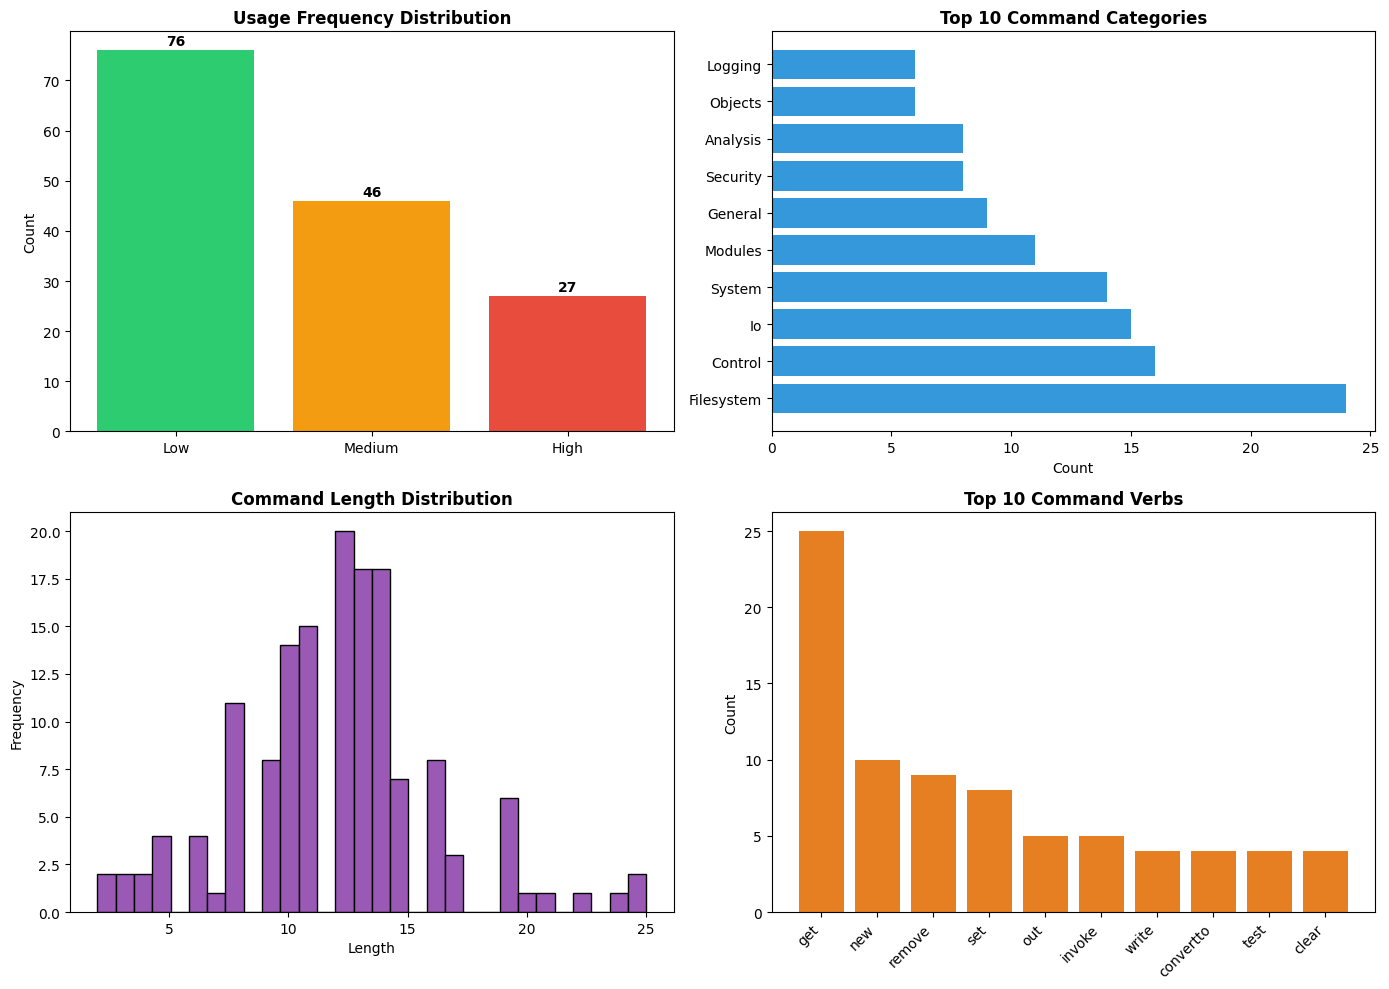


Dataset Statistics:
  Total commands: 149
  Average command length: 12.05
  Average parameters: 2.11
  Total categories: 19
  Total command verbs: 62

STEP 6: PREPARING DATA FOR ML MODEL

Features selected for ML model:
  1. command_length
  2. hyphen_count
  3. vowel_count
  4. frequency_encoded
  5. category_encoded
  6. verb_encoded
  7. parameters_count
  8. description_length

Data split:
  Training set: 119 samples (80%)
  Testing set: 30 samples (20%)

Feature matrix shape: (149, 8)
Sample features:
   command_length  hyphen_count  vowel_count  frequency_encoded  \
0              11             1            3                  3   
1              11             1            4                  3   
2              12             1            3                  3   
3              13             1            4                  2   
4              13             1            4                  3   
5              12             1            5                  3   
6               8 

In [15]:

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Load data (update path to your CSV file)
    df = load_data('powershell_commands.csv')
    
    # Clean data
    df_clean = clean_data(df)
    
    # Engineer features
    df_features = engineer_features(df_clean)
    
    # Encode categories
    df_encoded, freq_map, cat_map, verb_map = encode_categories(df_features)
    
    # Analyze and visualize
    analyze_and_visualize(df_encoded)
    
    # Prepare ML data
    X_train, X_test, y_train, y_test, features = prepare_ml_data(df_encoded)
    
    # Save cleaned data
    save_cleaned_data(df_encoded)
    
    print("\n" + "=" * 60)
    print("DATA PREPROCESSING COMPLETE!")
    print("=" * 60)
    print("\nYour data is ready for ML model training!")
    print(f"Next steps:")
    print(f"  1. Use X_train, y_train for training")
    print(f"  2. Use X_test, y_test for testing")
    print(f"  3. Choose an algorithm (LSTM, Random Forest, etc.)")
    print(f"  4. Train and evaluate your model")
    print("=" * 60)